In [1]:
from imp import reload
import cProfile

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cca
import gp

reload(cca)
reload(gp)

<module 'gp' from '/home/davidclark/Projects/ComplexityComponentsAnalysis/gp.py'>

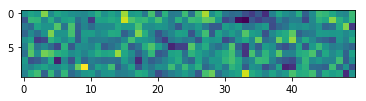

In [2]:
#Make Kernel
K = gp.gen_kernel("squared_exp", spatial_scale=0.5, temporal_scale=5.0)
T_pi = 5

#Generate data
T = 500
num_to_concat = 10

#Dimension of ambient space
N = 10

#Dimension of ambient space GP embedding
d = 3

#Noise covariance
noise_dim = 1e10
noise_variance = 1
noise_spectrum = noise_variance*np.exp(-np.arange(N)/(noise_dim/2))
noise_V = scipy.stats.ortho_group.rvs(N)
noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))

#Generate data 
X, E, full_pi, embedding_pi = gp.embed_gp(T, N, d, K, noise_cov, T_pi, num_to_concat=num_to_concat)
plt.imshow(X[:5*X.shape[1], :].T)
plt.show()

In [19]:
reload(cca)

cross_cov_mats_reg = cca.calc_cross_cov_mats_from_data(X, 2*T_pi, regularization="Abadir", reg_ops={"M":10, "S":25, "skip":T_pi})
cross_cov_mats_no_reg = cca.calc_cross_cov_mats_from_data(X, 2*T_pi, regularization=None)

pi_proj_reg_vals = np.zeros(N+1)
pi_proj_no_reg_vals = np.zeros(N+1)

for opt_dim in range(1, N+1):
    
    V_opt_reg = cca.run_cca(cross_cov_mats_reg, opt_dim, init="random")
    V_opt_no_reg = cca.run_cca(cross_cov_mats_no_reg, opt_dim, init="random")
    
    pi_proj_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_reg, proj=V_opt_reg)
    pi_proj_no_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_no_reg, proj=V_opt_no_reg)
    
    pi_proj_reg_vals[opt_dim] = pi_proj_reg
    pi_proj_no_reg_vals[opt_dim] = pi_proj_no_reg
    
    print(pi_proj_no_reg, pi_proj_reg)
    
    
    

0.692591400851245 0.6752737097326401
1.3055503613367359 1.3013959237526258
1.9085523335224344 1.9177961252954894
1.9873508044649884 1.946769098437048
2.07036122406819 1.9578430030515297
2.160915365760306 1.9671432806090694
2.250970555711428 1.9744696963605304
2.3426498209188886 1.9779345035113056
2.438944417998325 1.9800038731314347
2.5175939594211787 1.981251606300497


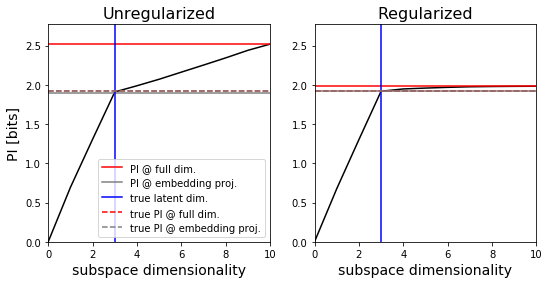

In [20]:
full_pi_reg = np.max(pi_proj_reg_vals)
embedding_pi_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_reg, proj=E)

full_pi_no_reg = np.max(pi_proj_no_reg_vals)
embedding_pi_no_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_no_reg, proj=E)

fig, axes = plt.subplots(1, 2, figsize=(8.75, 4))
ax1, ax2 = axes

ax1.plot(np.arange(N+1), pi_proj_no_reg_vals, c="black")
ax1.axhline(full_pi_no_reg, label="PI @ full dim.", c="red")
ax1.axhline(embedding_pi_no_reg, label="PI @ embedding proj.", c="gray")
ax1.axvline(d, label="true latent dim.", c="blue")

ax1.set_title("Unregularized", fontsize=16)
ax1.set_xlabel("subspace dimensionality", fontsize=14)
ax1.set_ylabel("PI [bits]", fontsize=14)

ax2.plot(np.arange(N+1), pi_proj_reg_vals, c="black")
ax2.axhline(full_pi_reg, label="PI @ full dim.", c="red")
ax2.axhline(embedding_pi_reg, label="PI @ embedding proj.", c="gray")
ax2.axvline(d, label="true latent dim.", c="blue")

ax1.axhline(full_pi, label="true PI @ full dim.", c="red", linestyle="--")
ax1.axhline(embedding_pi, label="true PI @ embedding proj.", c="gray", linestyle="--")
ax2.axhline(full_pi, label="true PI @ full dim.", c="red", linestyle="--")
ax2.axhline(embedding_pi, label="true PI @ embedding proj.", c="gray", linestyle="--")

ax2.set_title("Regularized", fontsize=16)
ax2.set_xlabel("subspace dimensionality", fontsize=14)
#ax2.set_ylabel("PI [bits]", fontsize=14)

ax1.legend()

y_max = np.max(np.concatenate((pi_proj_no_reg_vals, pi_proj_reg_vals)))*1.1

ax1.set_xlim([0, N])
ax1.set_ylim([0, y_max])

ax2.set_xlim([0, N])
ax2.set_ylim([0, y_max])

#plt.savefig("figs/N_10_d_3_Nsamps_5000_1xnoise_5dim.pdf", bbox_inches="tight")

plt.show()